# Estimating the SE of Lasso CV coefficients

This note comes from the following question: You have data $X, Y$ and you run a lasso-penalized linear regression of $Y$ onto $X$, with the lasso parameter tuned by cross-validation (CV). The question is how would you estimate the standard error (SE) of the coefficient estimates from this procedure?

I was asked this question as part of a quant research stats virtual interview. I did not have a good answer for this, as it was my understanding that the non-smoothness/selection property of the lasso renders the usual approach of bootstrapping the standard error inapplicable. I think all other resampling and subsampling schemes would also not work for similar reasons.

Surprisingly, my interviewer said that bootstrapping was the right approach. We discussed it for a time, but on the spot I was not able to convince him, but I also left unconvinced. Perhaps I misunderstood the question, but I did ask clarifying questions and believe this is the question that was asked.

In this notebook I investigate the effectiveness of this approach in a toy computational example. But first to build intuition, I will repeat an analysis of a simplified version of the problem from my friend Kevin Guo.

## The simplest lasso

Consider the following setting. We have $n$ samples $X_1,\dots, X_n$ where $X_i \sim \mathcal{N}(\mu,1)$. We want to estimate $\mu$ with the soft-thresholding estimator 
$$
\hat\mu = \mathrm{sign}(X)\max(|\bar X| - \lambda, 0)
$$ 
We will consider $\lambda = 1/\sqrt n$ as this is the size at which selection is "interesting"; $\lambda = o(1/\sqrt n)$ will essentially result in $\hat \mu = \bar X$, while $\lambda = \omega(1/\sqrt n)$ will result in $\hat\mu = \mathrm{sign}(X)(|\bar X| - \lambda)$, which will overshrink the estimator. Also, CV should end up picking $\lambda = O(1/\sqrt n)$ anyways.
Now if we consider the case where $\mu=0$, then $\sqrt n \bar X \dot\sim \mathcal{N}(0, 1)$, thus $|\sqrt n \bar X| \ge 2$ with moderate probability. In such cases, the bootstrap statistic $\bar X^*$ will have the approximate distribution
$$\sqrt n \bar X^* \dot\sim\mathcal{N}(\nu,1)$$
where $|\nu| > 2$. Thus we can see that although $\bar X$ will be soft-thresholded with roughly $2/3$ probability, the bootstrap statistic $\bar X^*$ is almost never soft-thresholded $5\%$ of the time.

Hopefullly that analysis helps build intuition about the problem. The non-smoothness inherent to the lasso soft-thresholding causes the bootstrap estimator to fail. Now let us run a simulation to verify this.

# Simulations on estimating the Lasso CV standard error

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, LassoCV

In [2]:
n = 200
p = 20
s = 3
snr = 1.

niter = 1000
nboot = 1000

In [3]:
np.random.seed(1)

In [4]:
beta_active = np.random.uniform(-1,1,size=s)
beta = np.zeros(p)
beta[:s] = beta_active

In [5]:
beta_active

array([-0.16595599,  0.44064899, -0.99977125])

# Compute ground truth by Monte-Carlo

In [6]:
beta_hats = np.zeros((niter,p))
m = LassoCV(fit_intercept=True)
for i in range(niter):
    X = np.random.randn(n,p)
    mu = X[:,:s] @ beta_active
    sigma = np.sqrt(np.var(mu) / snr)
    y = mu + sigma*np.random.randn(n)

    m.fit(X, y)
    beta_hats[i,:] = m.coef_

In [7]:
beta_boots = np.zeros((nboot, p))
for b in range(nboot):
    b_idx = np.random.choice(n,size=n,replace=True)
    X_b = X[b_idx,:]
    y_b = y[b_idx]

    m.fit(X_b, y_b)
    beta_boots[b,:] = m.coef_

In [8]:
beta_boots.var(0)[:s], beta_hats.var(0)[:s]

(array([0.00390387, 0.00605922, 0.00687528]),
 array([0.00554154, 0.00683034, 0.00664847]))

In [9]:
running_var = pd.DataFrame(beta_hats[:,:s]).rolling(window=niter, min_periods=5).var()
running_boot_var = pd.DataFrame(beta_boots[:,:s]).rolling(window=nboot, min_periods=5).var()

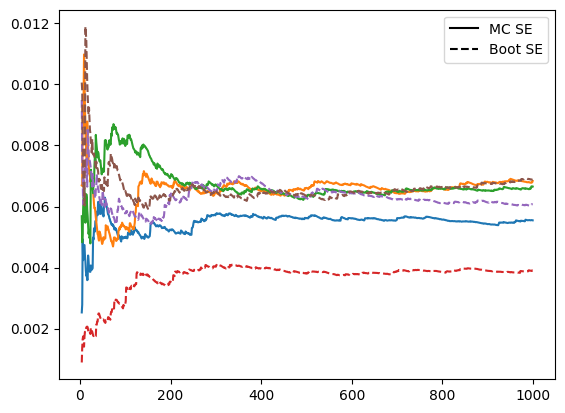

In [10]:
ax = running_var.plot.line(legend=False)
running_boot_var.plot.line(legend=False, linestyle='--', ax=ax)
dummy_line = plt.Line2D([0], [0], color='black', linestyle='-')
dummy_dash = plt.Line2D([0], [0], color='black', linestyle='--')
legend_elements = [dummy_line, dummy_dash]
legend_labels = ["MC SE", "Boot SE"]
plt.legend(legend_elements, legend_labels)

### One of the boostrap SE estimates (red) is much smaller than the MC SE estimates

This clearly indicates an issue with the bootstrap method. It happens that this coefficient is the smallest of our active set, and is near 0

In [11]:
beta_active[:s]

array([-0.16595599,  0.44064899, -0.99977125])

Thus it is the coefficient whose SE estimate we would expect to most suffer from the lasso selection. We can plot that coefficients SE estimates alone.

In [12]:
true_var = running_var.iloc[:,0]
boot_var = running_boot_var.iloc[:,0]

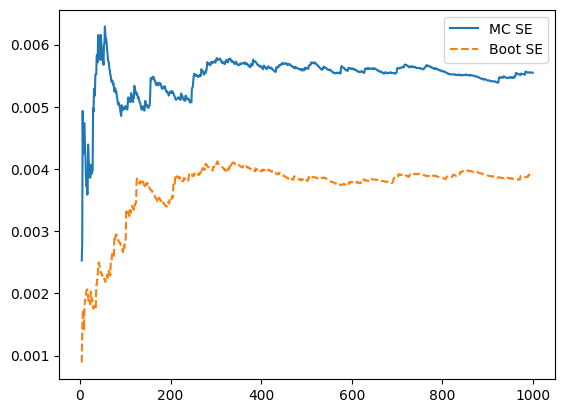

In [13]:
ax2 = true_var.plot.line(legend=False)
boot_var.plot.line(legend=False, linestyle='--', ax=ax2)
dummy_line = plt.Line2D([0], [0], color='tab:blue', linestyle='-')
dummy_dash = plt.Line2D([0], [0], color='tab:orange', linestyle='--')
legend_elements = [dummy_line, dummy_dash]
legend_labels = ["MC SE", "Boot SE"]
plt.legend(legend_elements, legend_labels)

### This corroborates the intuition we built in our simple theoretical analysis.

# Conclusion

We have seen that the bootstrap estimator of Lasso CV SE can be wrong, underestimating the SE when the coefficient is near 0, both in a simple theoretical example and in simulation. 

I do not know of a better method with theoretical guarantees to work, but perhaps a decent practical approach is to upwardly bias the bootstrap SE estimates proportionate to how close the coefficient estimates are to 0.